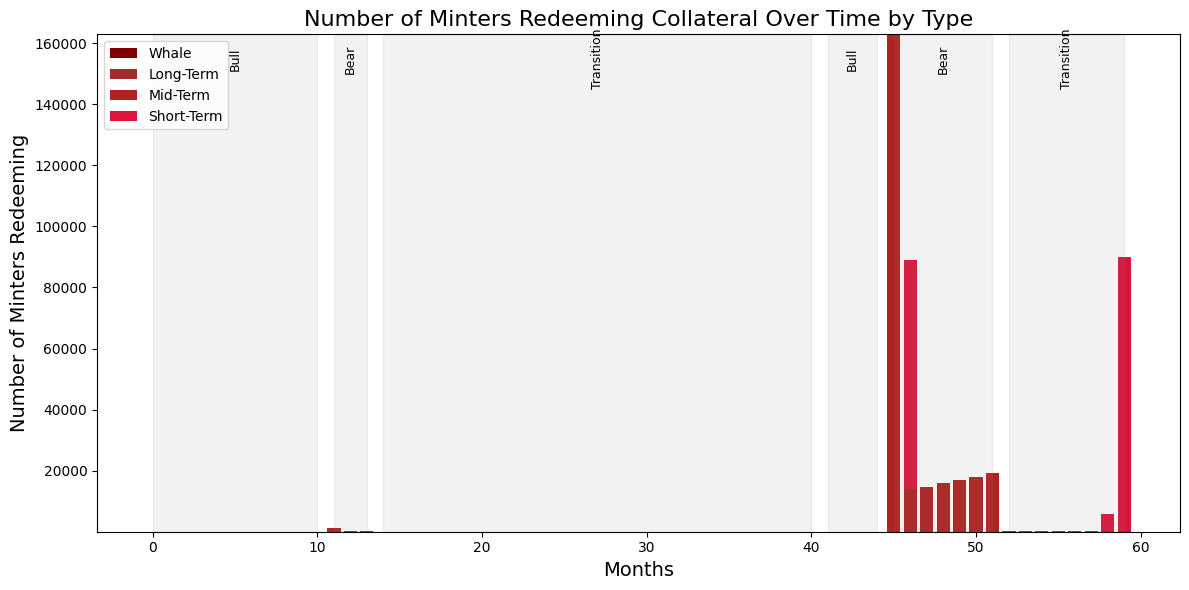

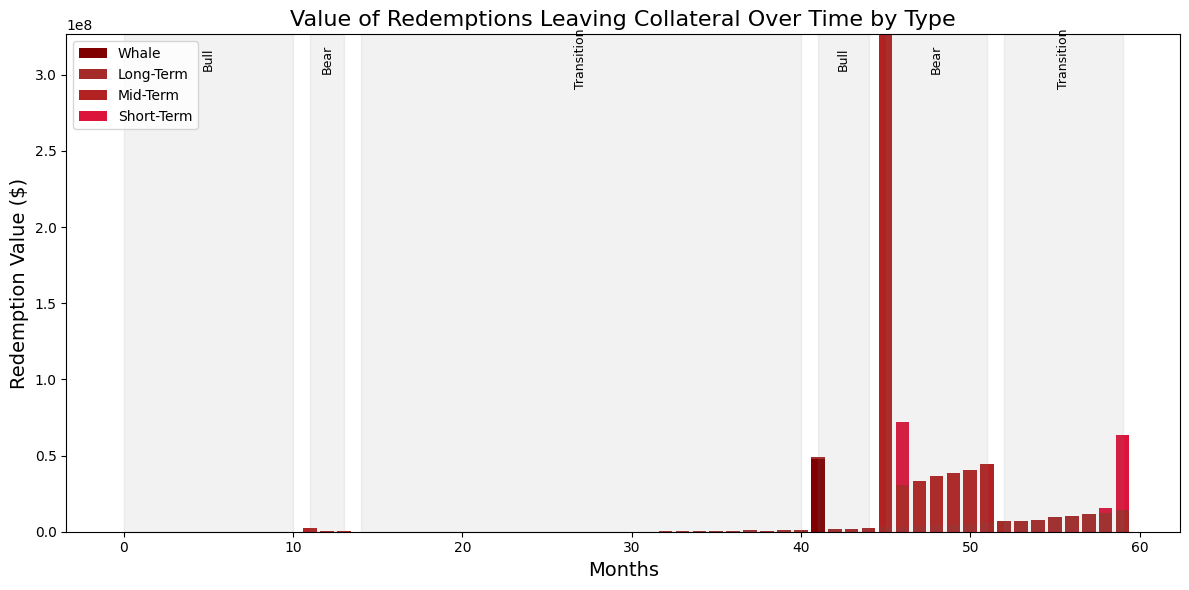

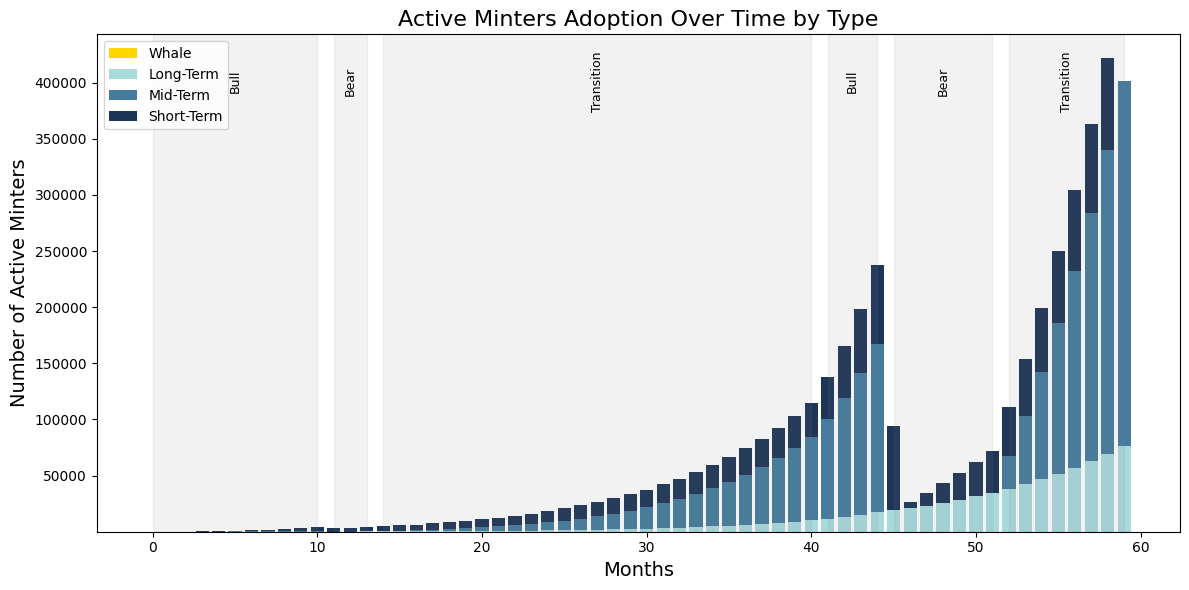

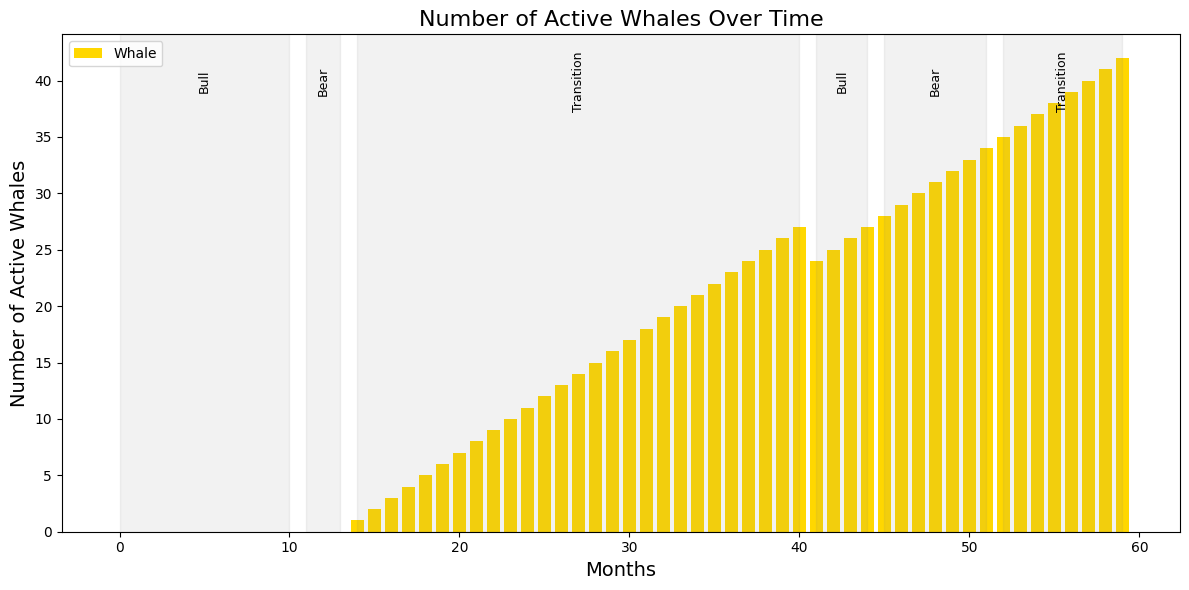

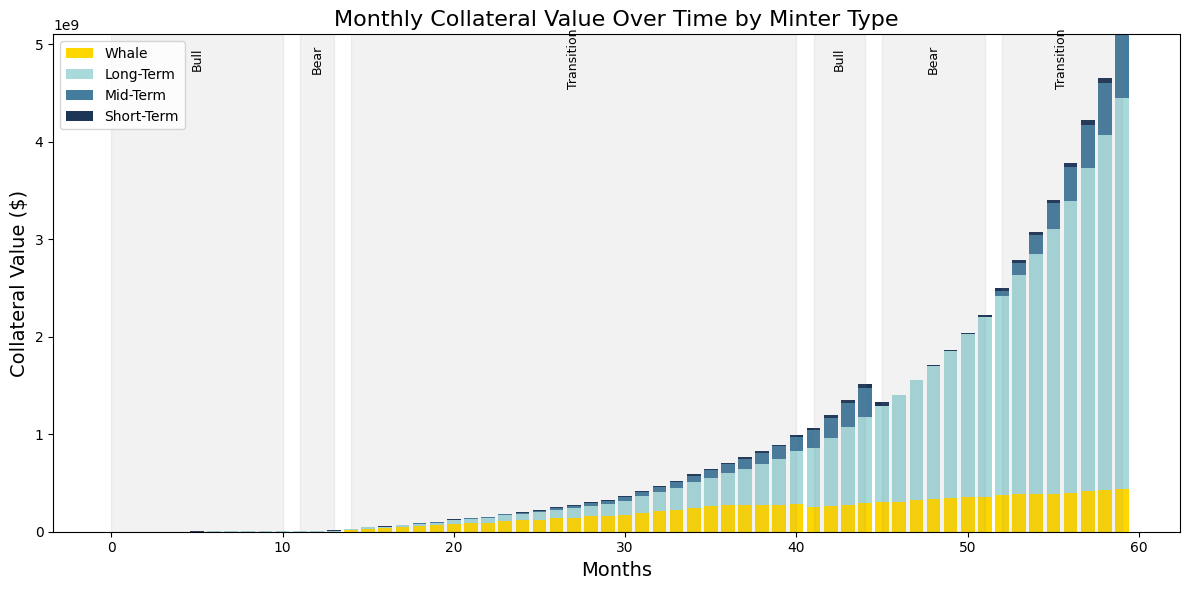

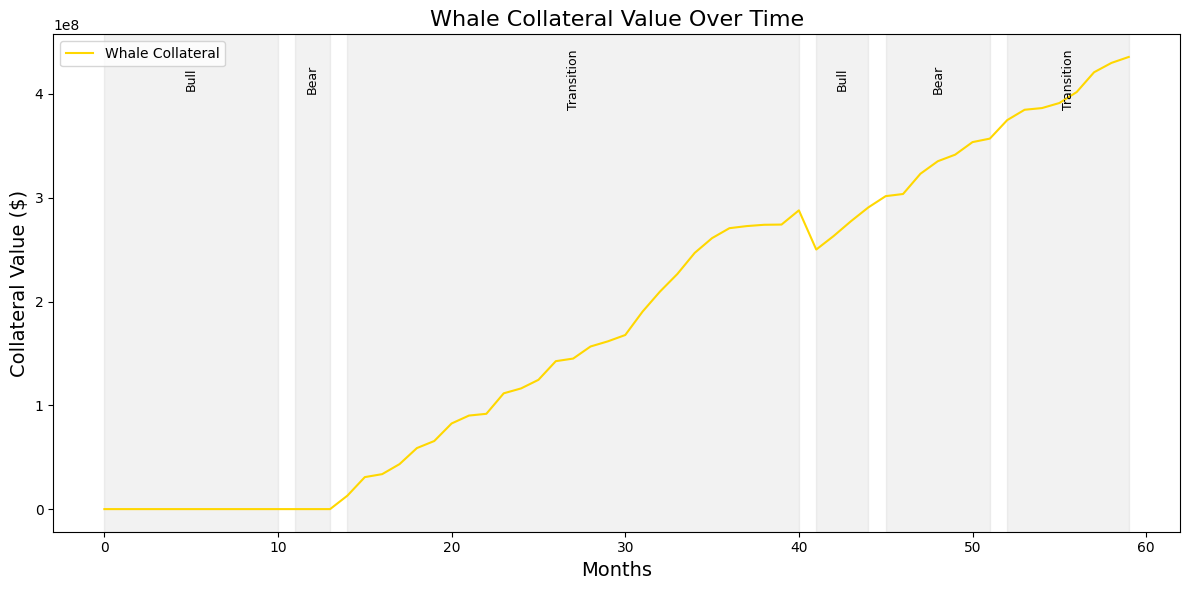

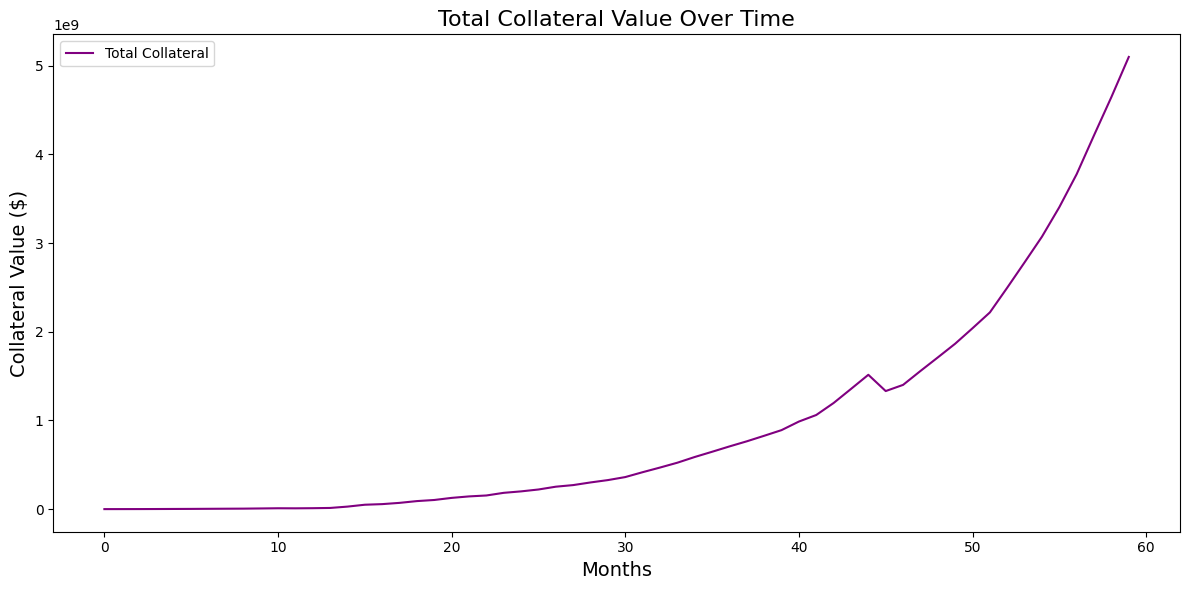

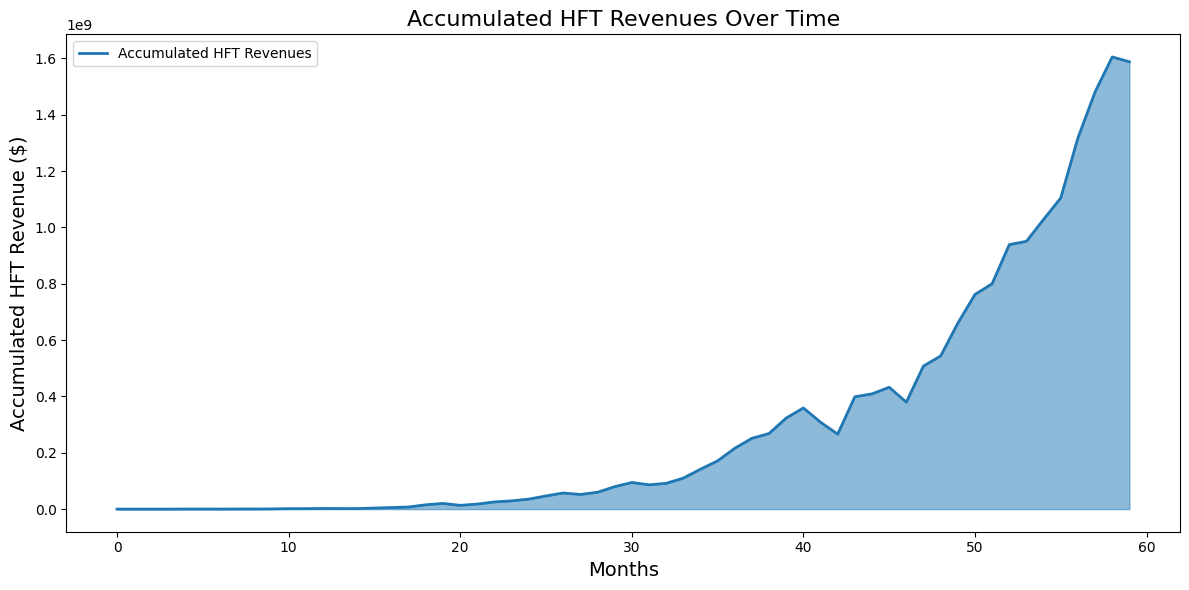

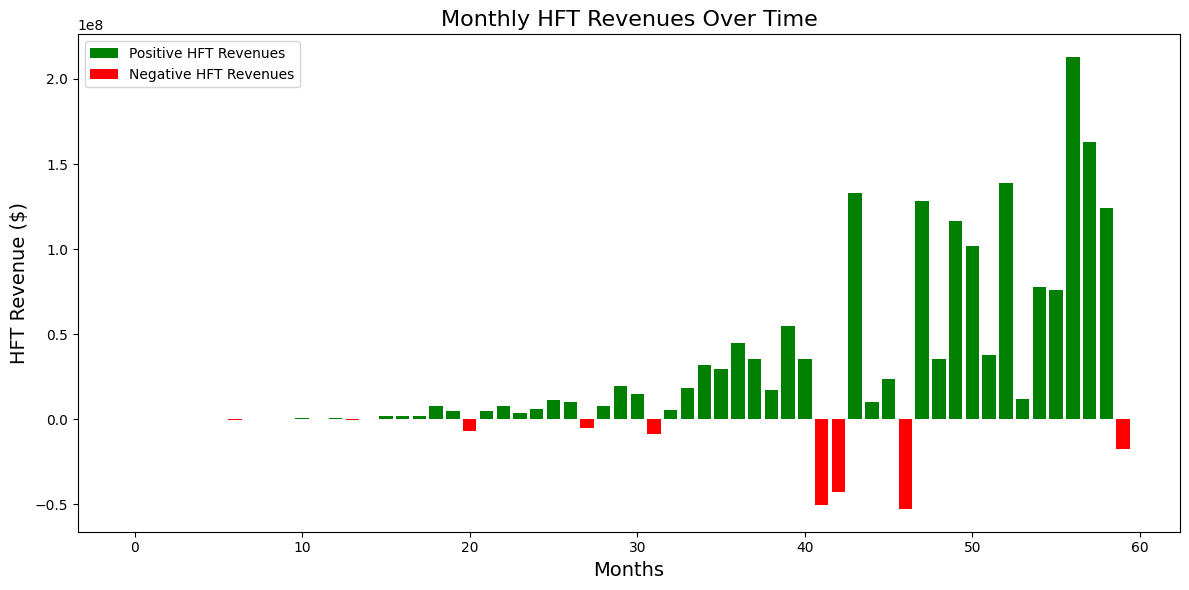

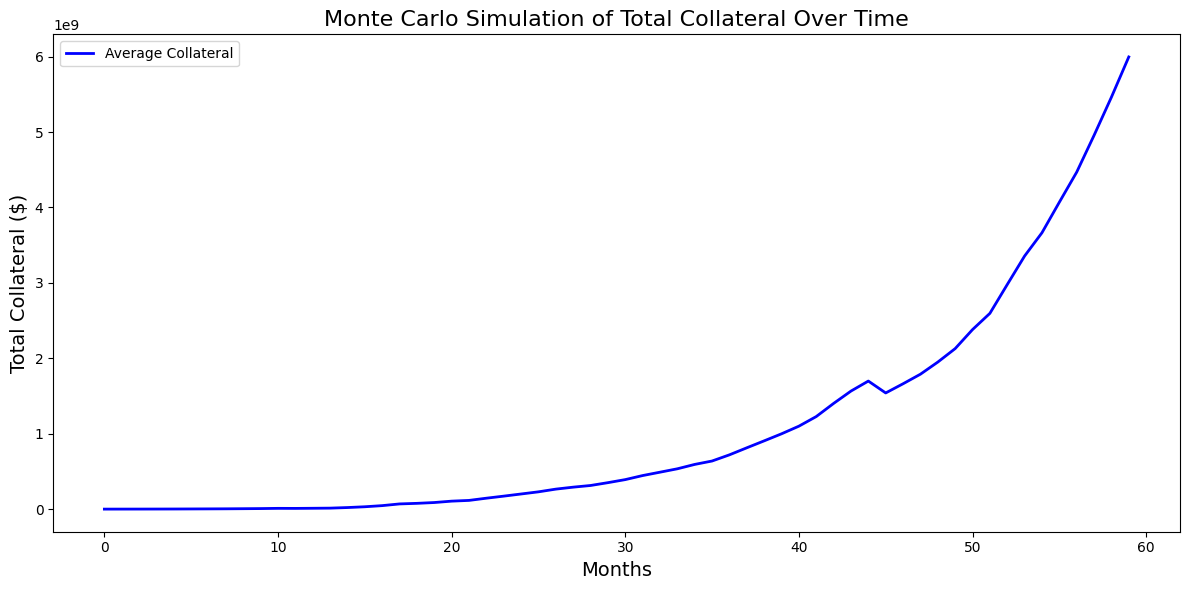

Mean Final HFT Revenue: $1,617,768,898.80
Median Final HFT Revenue: $1,617,768,898.80
Standard Deviation: $0.00
5th Percentile: $1,617,768,898.80
Median: $1,617,768,898.80
95th Percentile: $1,617,768,898.80
Probability of Negative HFT Revenues: 0.00%


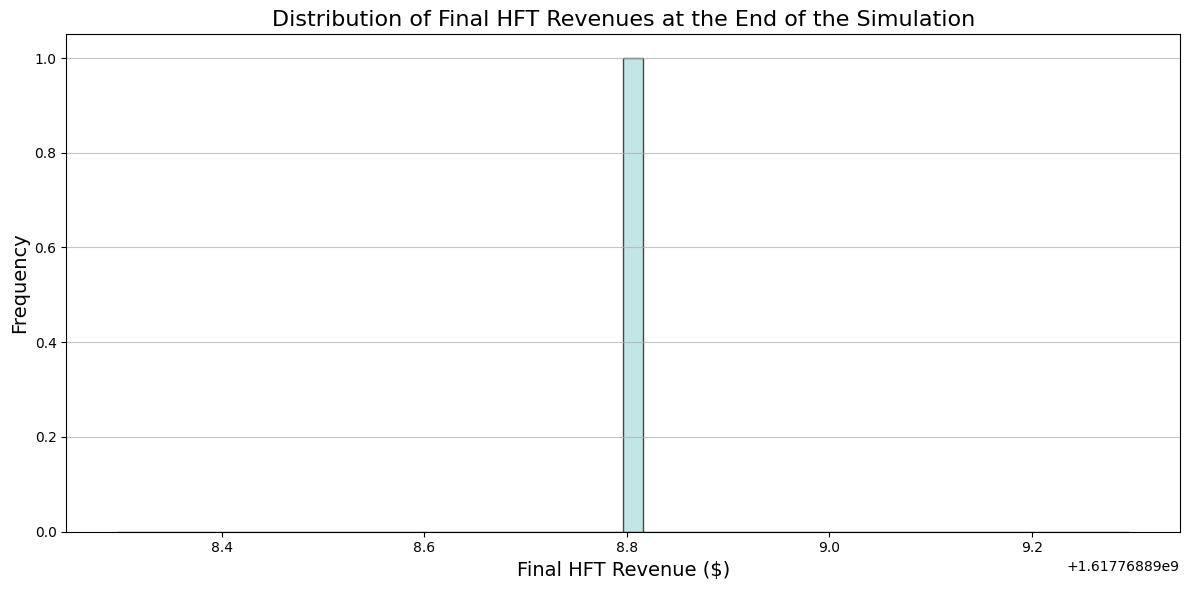

Mean Monthly HFT Revenue: $26,962,814.98
Median Monthly HFT Revenue: $2,278,567.70
Standard Deviation: $91,058,535.73
5th Percentile: $-52,997,706.85
Median: $2,278,567.70
95th Percentile: $155,527,709.73
Probability of Negative Monthly HFT Revenues: 26.67%


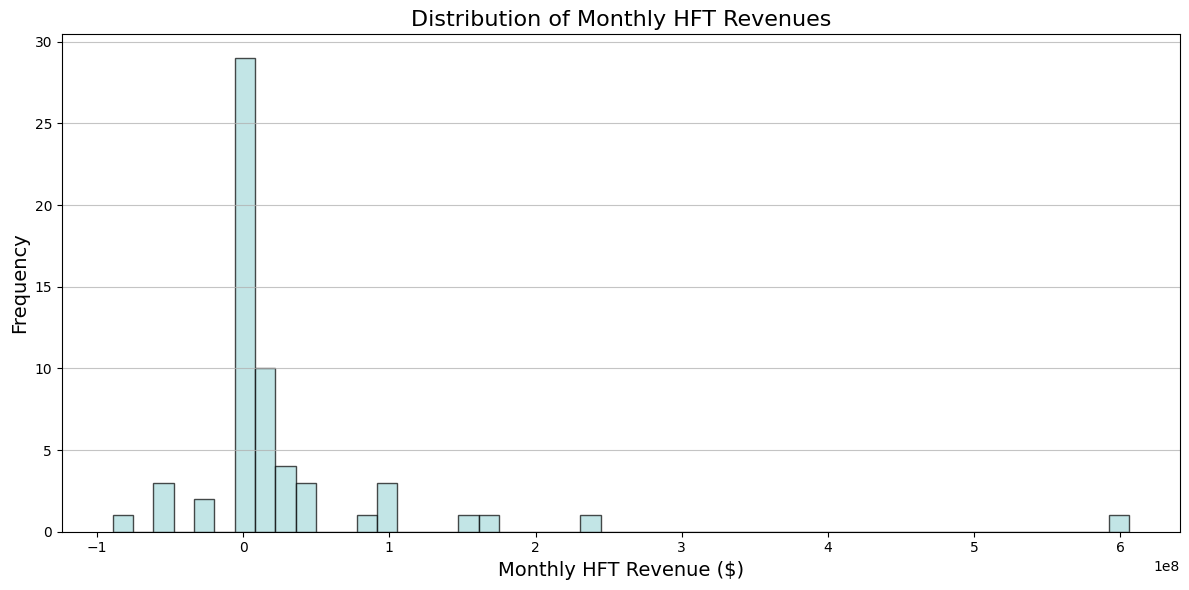

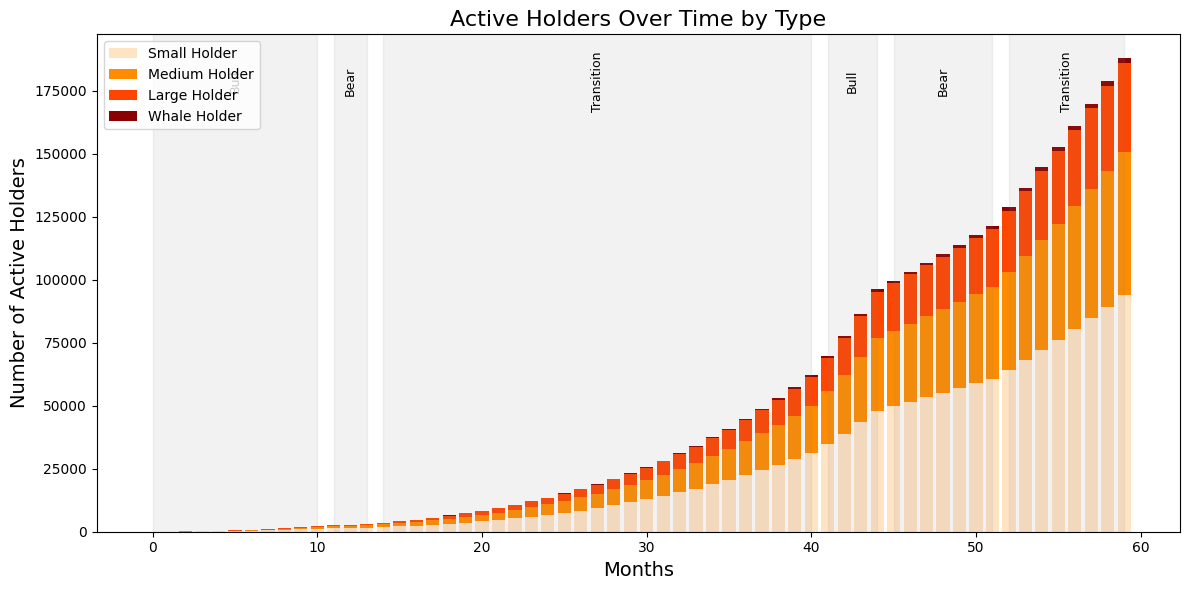

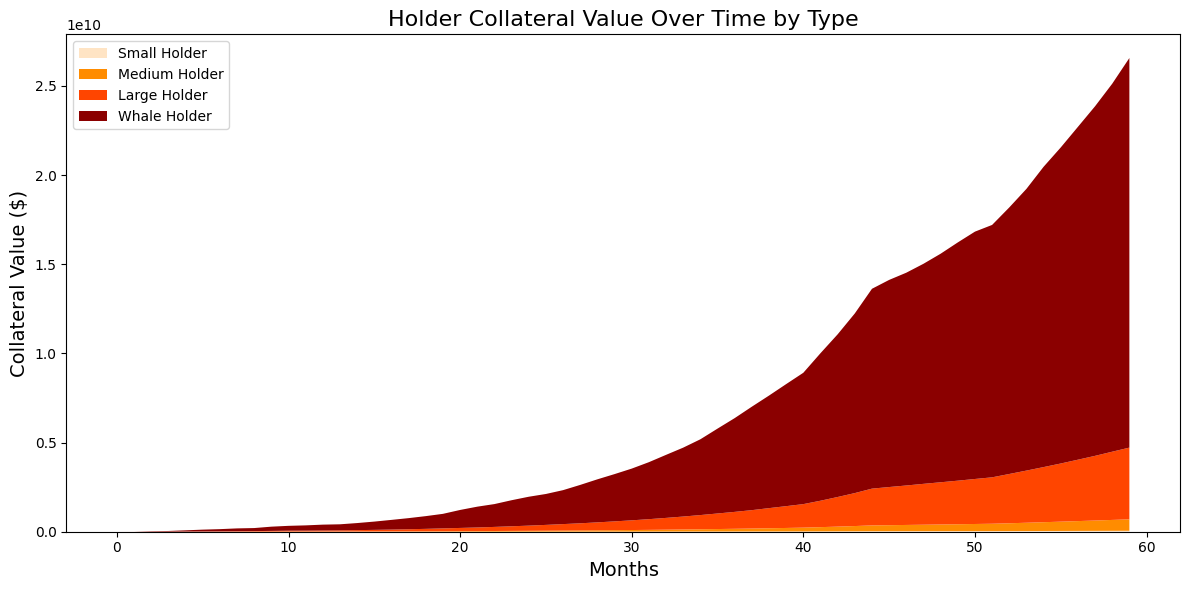

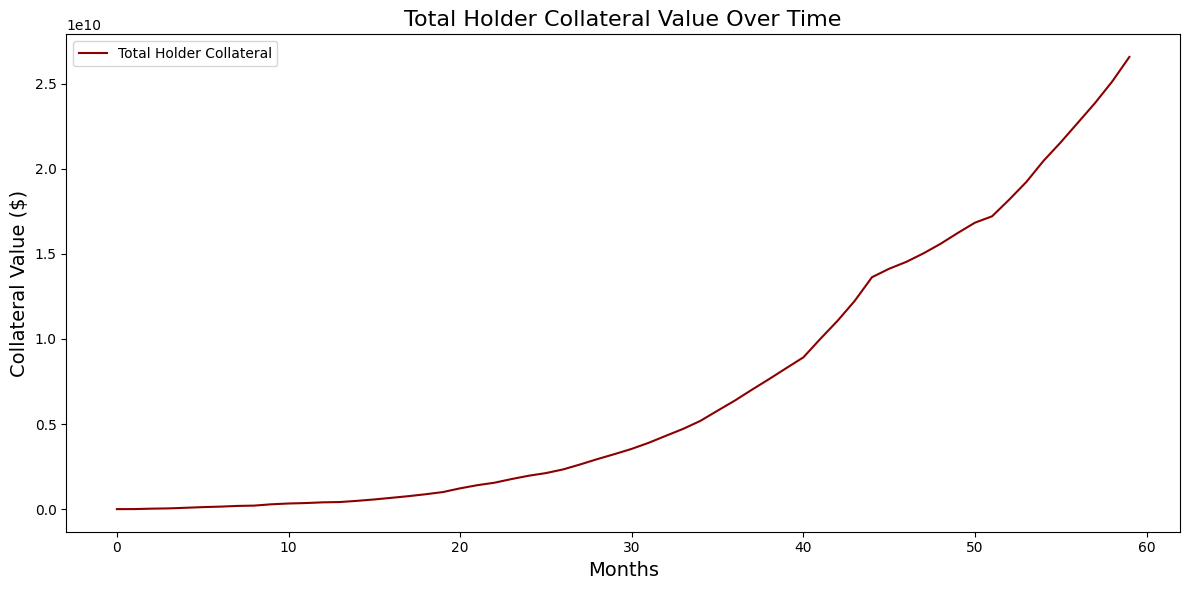

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(88)

# ==========================
# 1. Simulation Parameters
# ==========================

# Time Horizon
total_years = 5 # ENTER THE NUMBER OF YEARS YOU WANT THE SIMULATION TO BE RUN ON
total_months = total_years * 12
time_steps = np.arange(total_months)

# Generate Market Phases with Random Durations
market_phases_sequence = ['Bull', 'Bear', 'Transition']

def generate_market_phases(time_horizon):
    phases = []
    phase_start_months = []
    phase_end_months = []
    month = 0
    phase_index = 0
    while month < time_horizon:
        phase = market_phases_sequence[phase_index % len(market_phases_sequence)]
        if phase == 'Bull' or phase == 'Bear':
            duration = np.random.randint(3, 13)  # 3 to 12 months
        else:
            duration = np.random.randint(12, 37)  # 12 to 36 months
        end_month = min(month + duration, time_horizon)
        phases.extend([phase] * (end_month - month))
        phase_start_months.append(month)
        phase_end_months.append(end_month - 1)
        month = end_month
        phase_index += 1
    # Ensure 'phases' is at least 'time_horizon' in length
    if len(phases) < time_horizon:
        phases.extend([phases[-1]] * (time_horizon - len(phases)))
    return phases[:time_horizon], phase_start_months, phase_end_months

market_schedule, phase_start_months, phase_end_months = generate_market_phases(total_months)

# Collateral Composition
collateral_weights = {
    'BTC': 0.00,
    'ETH': 0.00,
    'Stablecoin': 1.00
}

# Asset Parameters (Mean and Volatility for Each Phase)
asset_params = {
    'Bull': {
        'BTC': {'annual_return': 1.80, 'annual_volatility': 0.75},
        'ETH': {'annual_return': 4.30, 'annual_volatility': 1.00},
        'Stablecoin': {'annual_return': 0.00, 'annual_volatility': 0.02}
    },
    'Bear': {
        'BTC': {'annual_return': -0.60, 'annual_volatility': 0.65},
        'ETH': {'annual_return': -0.70, 'annual_volatility': 0.85},
        'Stablecoin': {'annual_return': 0.00, 'annual_volatility': 0.02}
    },
    'Transition': {
        'BTC': {'annual_return': 0.60, 'annual_volatility': 0.50},
        'ETH': {'annual_return': 0.70, 'annual_volatility': 0.55},
        'Stablecoin': {'annual_return': 0.00, 'annual_volatility': 0.02}
    }
}

# Fees
performance_fee = 0.06        # 6% going to Protocol Treasury

# Minter Types
minter_types = ['Whale', 'Long-Term', 'Mid-Term', 'Short-Term']

# HFT Return Parameters
hft_annual_return = 0.35
hft_annual_volatility = 0.142  # Derived from past Sharpe Ratio
hft_monthly_return = hft_annual_return / 12
hft_monthly_volatility = hft_annual_volatility / np.sqrt(12)

# ==========================
# 2. Market Conditions
# ==========================

def generate_market_conditions():
    """
    Simulates asset returns over time based on market phases.
    """
    asset_returns = {
        'BTC': np.zeros(total_months),
        'ETH': np.zeros(total_months),
        'Stablecoin': np.zeros(total_months)
    }

    for month in range(total_months):
        phase = market_schedule[month]
        for asset in ['BTC', 'ETH', 'Stablecoin']:
            params = asset_params[phase][asset]
            mu = params['annual_return'] / 12
            sigma = params['annual_volatility'] / np.sqrt(12)
            # Using Student's t-distribution with 3 degrees of freedom for fat tails
            ret = np.random.standard_t(df=3) * sigma + mu
            # Ensure returns do not fall below -99%
            ret = max(ret, -0.99)
            asset_returns[asset][month] = ret

    return asset_returns

# ==========================
# 3. Minters' Adoption
# ==========================

def get_time_dependent_growth_rate(t):
    if t <= 60:
        r0 = 0.2225  # Initial growth rate
        r1 = 0.10    # Growth rate at t = 60 months
        T1 = 60
        k1 = np.log(r0 / r1) / T1
        r_t = r0 * np.exp(-k1 * t)
    else:
        r0 = 0.10    # Growth rate at t = 60 months
        r1 = 0.0005  # Growth rate at the end of simulation (0.05%)
        T2 = total_months - 60
        k2 = np.log(r0 / r1) / T2
        r_t = r0 * np.exp(-k2 * (t - 60))
    return r_t

def get_minter_type_distribution(month):
    whale_proportion = 0.02  # Keep whale proportion constant at 0.5%

    # Adjust other proportions accordingly
    total_other = 1 - whale_proportion
    total_other_types = 0.08 + 0.35 + 0.55  # Sum of initial proportions
    adjusted_distribution = {
        'Whale': whale_proportion,
        'Long-Term': (0.08 / total_other_types) * total_other,
        'Mid-Term': (0.35 / total_other_types) * total_other,
        'Short-Term': (0.55 / total_other_types) * total_other
    }
    return adjusted_distribution

def get_market_entry_multiplier(minter_type, phase):
    """
    Returns the market entry multiplier based on minter type and current market phase.
    """
    if minter_type == 'Whale':
        multipliers = {'Bull': 1.2, 'Transition': 1.0, 'Bear': 0.8}
    elif minter_type == 'Long-Term':
        multipliers = {'Bull': 1.1, 'Transition': 1.0, 'Bear': 0.9}
    elif minter_type == 'Mid-Term':
        multipliers = {'Bull': 1.5, 'Transition': 1.0, 'Bear': 0.7}
    elif minter_type == 'Short-Term':
        multipliers = {'Bull': 1.8, 'Transition': 0.5, 'Bear': 0.6}
    else:
        multipliers = {'Bull': 1.0, 'Transition': 1.0, 'Bear': 1.0}
    return multipliers.get(phase, 1.0)

def generate_minters():
    """
    Generates the number of new minters per month for each type.
    """
    N0 = 200  # Starting number of minters
    cumulative_entries = np.zeros(total_months)
    cumulative_entries[0] = N0

    # Get initial minter type distribution
    minter_type_distribution = get_minter_type_distribution(0)
    initial_minters_type = {minter_type: int(N0 * minter_type_distribution[minter_type]) for minter_type in minter_types}

    # Initialize cumulative entries per minter type
    cumulative_entries_type = {minter_type: np.zeros(total_months) for minter_type in minter_types}
    for minter_type in minter_types:
        cumulative_entries_type[minter_type][0] = initial_minters_type[minter_type]

    # Initialize minters dictionary
    minters = {minter_type: {'new': np.zeros(total_months, dtype=int),
                             'exit': np.zeros(total_months, dtype=int)} for minter_type in minter_types}

    # Handle Whale entries separately
    whale_annual_new = []
    annual_whale_entries = []

    # First year
    first_year_whales = np.random.randint(5, 11)  # Between 5 and 10 inclusive
    whale_annual_new.append(first_year_whales)
    annual_whale_entries.append(first_year_whales)

    # Subsequent years
    for year in range(1, total_years):
        increment = np.random.randint(2, 7)  # Between 2 and 6 inclusive
        new_whales = whale_annual_new[-1] + increment
        whale_annual_new.append(new_whales)
        annual_whale_entries.append(new_whales)

    # Now distribute annual_new_whales over months
    whale_new_entries = np.zeros(total_months, dtype=int)
    current_month = 0
    for year, annual_whales in enumerate(annual_whale_entries):
        months_in_year = 12
        for month_in_year in range(months_in_year):
            month = current_month + month_in_year
            if month >= total_months:
                break
            phase = market_schedule[month]
            multiplier = get_market_entry_multiplier('Whale', phase)
            # Adjust entries by market phase multiplier
            monthly_whales = int((annual_whales / 12) * multiplier)
            whale_new_entries[month] = monthly_whales
        current_month += months_in_year

    minters['Whale']['new'] = whale_new_entries
    cumulative_entries_type['Whale'] = np.cumsum(whale_new_entries)

    # For other minter types
    for month in range(1, total_months):
        phase = market_schedule[month]
        r_t = get_time_dependent_growth_rate(month)

        for minter_type in minter_types:
            if minter_type == 'Whale':
                continue  # Already handled
            # Apply market entry multiplier
            multiplier = get_market_entry_multiplier(minter_type, phase)

            # Calculate expected number of new minters based on cumulative entries
            expected_new_minters = cumulative_entries_type[minter_type][month - 1] * r_t * multiplier

            # Ensure expected_new_minters is non-negative
            expected_new_minters = max(expected_new_minters, 0)

            # Sample from Poisson distribution to get new minters
            new_minters = np.random.poisson(expected_new_minters)

            minters[minter_type]['new'][month] = new_minters

            # Update cumulative entries per type
            cumulative_entries_type[minter_type][month] = cumulative_entries_type[minter_type][month - 1] + new_minters

        # Update total cumulative entries
        cumulative_entries[month] = cumulative_entries[month - 1] + sum(minters[minter_type]['new'][month] for minter_type in minter_types)

    return minters, cumulative_entries_type

def calculate_minters_exit(minters, cumulative_entries_type, asset_returns, market_schedule):
    # Identify significant market events
    small_crash_months = identify_significant_negative_returns(asset_returns, threshold=-0.15)
    large_crash_months = identify_significant_negative_returns(asset_returns, threshold=-0.30)
    bear_market_months = [i for i, phase in enumerate(market_schedule) if phase == 'Bear']

    # Identify start months of bull markets
    bull_market_months = [i for i, phase in enumerate(market_schedule) if phase == 'Bull']
    bull_market_starts = [bull_market_months[0]]
    for i in range(1, len(bull_market_months)):
        if bull_market_months[i] - bull_market_months[i - 1] > 1:
            bull_market_starts.append(bull_market_months[i])

    # For whales, determine exit starting from the second bull market
    if len(bull_market_starts) > 1:
        whale_exit_starts = bull_market_starts[1:]  # Starting from the second bull market
    else:
        whale_exit_starts = []

    # Keep track of cumulative whale entries per year
    whale_yearly_entries = []
    current_year_entries = 0
    for month in range(total_months):
        current_year_entries += minters['Whale']['new'][month]
        if (month + 1) % 12 == 0:
            whale_yearly_entries.append(current_year_entries)
            current_year_entries = 0

    whale_exit_schedule = np.zeros(total_months, dtype=int)
    # Now, for each year starting from the second bull market, schedule exits
    for idx, exit_start_month in enumerate(whale_exit_starts):
        # For the corresponding year, get the annual new whales
        year_idx = exit_start_month // 12
        if year_idx < len(whale_yearly_entries):
            annual_new_whales = whale_yearly_entries[year_idx]
        else:
            annual_new_whales = 0

        # Number of whales to exit
        if market_schedule[exit_start_month] == 'Bull':
            num_exiting_whales = np.random.randint(2, 5)  # 2 to 4 inclusive
        else:
            num_exiting_whales = np.random.randint(1, 4)  # 1 to 3 inclusive

        num_exiting_whales = min(num_exiting_whales, annual_new_whales)

        # Schedule the exits at the exit_start_month
        whale_exit_schedule[exit_start_month] += num_exiting_whales

    # Assign whale exits
    minters['Whale']['exit'] = whale_exit_schedule

    # For other minter types
    for minter_type in minter_types:
        if minter_type == 'Whale':
            continue  # Already handled
        for month in range(total_months):
            new_minters = minters[minter_type]['new'][month]
            if new_minters == 0:
                continue

            if minter_type == 'Long-Term':
                # Long-Term minters have a slow redemption rate
                annual_redemption_rate = 0.05
                monthly_redemption_rate = annual_redemption_rate / 12
                remaining_minters = new_minters
                for m in range(1, total_months - month):
                    exit_month = month + m
                    if exit_month < total_months:
                        expected_exit = int(remaining_minters * monthly_redemption_rate)
                        minters[minter_type]['exit'][exit_month] += expected_exit
                        remaining_minters -= expected_exit
                        if remaining_minters <= 0:
                            break
                    else:
                        break  # Remaining minters remain active

            elif minter_type == 'Mid-Term':
                # Exit during the next Bear Market or on a large crash
                future_bear_months = [m for m in bear_market_months if m >= month]
                future_large_crash_months = [m for m in large_crash_months if m >= month]

                if future_bear_months:
                    exit_month = future_bear_months[0]  # First bear month after current month
                    minters[minter_type]['exit'][exit_month] += new_minters
                elif future_large_crash_months:
                    exit_month = future_large_crash_months[0]
                    minters[minter_type]['exit'][exit_month] += new_minters
                else:
                    pass  # Remain active if no future bear markets or large crashes

            elif minter_type == 'Short-Term':
                # Exit after experiencing two consecutive small crashes
                crash_sequence = find_consecutive_crashes(small_crash_months, month, required_consecutive=2)
                if crash_sequence:
                    exit_month = crash_sequence[-1]  # Exit after the second crash
                    minters[minter_type]['exit'][exit_month] += new_minters
                else:
                    # Exit after 12 months if no crashes occur
                    exit_month = min(month + 12, total_months - 1)
                    minters[minter_type]['exit'][exit_month] += new_minters

    # Ensure that exits do not exceed active minters
    for minter_type in minter_types:
        for month in range(total_months):
            # Handle month == 0 separately
            if month == 0:
                previous_cumulative_exit = 0
            else:
                previous_cumulative_exit = np.cumsum(minters[minter_type]['exit'][:month])[month - 1]

            active_minters_count = cumulative_entries_type[minter_type][month] - previous_cumulative_exit

            if minters[minter_type]['exit'][month] > active_minters_count:
                minters[minter_type]['exit'][month] = active_minters_count

    return minters


# ==========================
# 4. Simulating Collateral Value
# ==========================

def simulate_collateral(minters, asset_returns):
    """
    Simulates the collateral value over time for each minter type and overall.
    Computes redemptions based on differences in active minters and collateral.
    """
    # Initialize collateral arrays
    collateral_per_type = {minter_type: np.zeros(total_months) for minter_type in minter_types}
    total_collateral = np.zeros(total_months)

    # Initialize active minters
    active_minters = {minter_type: np.zeros(total_months, dtype=int) for minter_type in minter_types}

    # Initialize redemption data
    redemptions_per_type = {minter_type: np.zeros(total_months, dtype=int) for minter_type in minter_types}
    redemption_values_per_type = {minter_type: np.zeros(total_months) for minter_type in minter_types}

    # Deposit amount ranges for each minter type
    deposit_ranges = {
        'Whale': (1000000, 20000000),
        'Long-Term': (5000, 100000),
        'Mid-Term': (1000, 3000),
        'Short-Term': (100, 1000)
    }

    # Initialize dictionaries to track individual minter balances
    minter_balances = {minter_type: [] for minter_type in minter_types}

    for month in range(total_months):
        # Calculate weighted asset returns for the current month
        weighted_return = sum(
            collateral_weights[asset] * asset_returns[asset][month]
            for asset in collateral_weights.keys()
        )

        for minter_type in minter_types:
            # Assign random deposits to new minters
            total_new_minters = minters[minter_type]['new'][month]
            deposit_min, deposit_max = deposit_ranges[minter_type]
            new_deposits = np.random.uniform(deposit_min, deposit_max, total_new_minters)
            # Add new minters to the balance list
            minter_balances[minter_type].extend(new_deposits)

            # Apply returns to existing minters
            if month > 0:
                minter_balances[minter_type] = [balance * (1 + weighted_return) for balance in minter_balances[minter_type]]

            # Determine exits
            total_exiting_minters = minters[minter_type]['exit'][month]
            if total_exiting_minters > 0:
                # Randomly select minters to exit
                exiting_indices = np.random.choice(len(minter_balances[minter_type]), total_exiting_minters, replace=False)
                exiting_balances = [minter_balances[minter_type][i] for i in exiting_indices]
                # Remove exiting minters from balances
                minter_balances[minter_type] = [balance for i, balance in enumerate(minter_balances[minter_type]) if i not in exiting_indices]
                # Record redemption data
                redemptions_per_type[minter_type][month] = total_exiting_minters
                redemption_values_per_type[minter_type][month] = sum(exiting_balances)
            else:
                redemptions_per_type[minter_type][month] = 0
                redemption_values_per_type[minter_type][month] = 0

            # Update active minters
            active_minters[minter_type][month] = len(minter_balances[minter_type])

            # Update collateral per type
            collateral_per_type[minter_type][month] = sum(minter_balances[minter_type])

        # Sum total collateral across all types
        total_collateral[month] = sum(collateral_per_type[minter_type][month] for minter_type in minter_types)

    return total_collateral, collateral_per_type, active_minters, redemptions_per_type, redemption_values_per_type

# ==========================
# 5. Simulating Holders
# ==========================

def get_holder_time_dependent_growth_rate(t):
    """
    Returns the time-dependent growth rate for holders.
    """
    r0 = 0.2225  # Initial growth rate for holders (12% per month)
    T = 60     # Time after which growth rate is minimal (5 years)
    r_end = 0.05  # Minimum growth rate (0.2% per month)
    k = np.log(r0 / r_end) / T
    r_t = r0 * np.exp(-k * t)
    return max(r_t, r_end)  # Ensure growth rate does not fall below minimum

def get_holder_phase_multiplier(phase):
    """
    Returns a multiplier for holder growth rate based on market phase.
    """
    multipliers = {'Bull': 1.5, 'Transition': 1.0, 'Bear': 0.5}
    return multipliers.get(phase, 1.0)

def get_holder_type_distribution(holder_type):
    """
    Returns the distribution proportion for each holder type.
    """
    distribution = {
        'Small Holder': 0.50,
        'Medium Holder': 0.30,
        'Large Holder': 0.19,
        'Whale Holder': 0.01
    }
    return distribution.get(holder_type, 0)

def generate_holders():
    """
    Generates the number of new holders per month for each type based on the time-dependent growth rate.
    """
    # Initial number of holders
    H0 = 200  # Starting number of holders (lower than before)
    H = np.zeros(total_months)
    H[0] = H0

    # Initialize holders dictionary
    holders = {holder_type: {'new': np.zeros(total_months, dtype=int), 'exit': np.zeros(total_months, dtype=int)} for holder_type in holder_types}

    for month in range(1, total_months):
        phase = market_schedule[month]

        # Get time-dependent growth rate for holders
        r = get_holder_time_dependent_growth_rate(month)

        # Apply market phase multiplier to holder growth rate
        phase_multiplier = get_holder_phase_multiplier(phase)
        r *= phase_multiplier

        # Calculate new holders
        total_new_holders = H[month - 1] * r

        # Update total number of holders
        H[month] = H[month - 1] + total_new_holders

        # Distribute new holders among types
        for holder_type in holder_types:
            # Apply holder type distribution
            distribution = get_holder_type_distribution(holder_type)
            adjusted_new = total_new_holders * distribution
            # Convert adjusted_new to integer number of holders
            new_holders = np.random.poisson(max(adjusted_new, 0))
            holders[holder_type]['new'][month] = new_holders

        # Simple exit model: holders exit randomly with a small probability
        for holder_type in holder_types:
            exit_rate = 0.01  # 1% monthly exit rate
            exits = int(holders[holder_type]['new'][month] * exit_rate)
            holders[holder_type]['exit'][month] = exits

    return holders

def simulate_holder_collateral(holders, asset_returns):
    """
    Simulates the collateral value over time for each holder type and overall.
    """
    # Initialize collateral arrays
    holder_collateral_per_type = {holder_type: np.zeros(total_months) for holder_type in holder_types}
    total_holder_collateral = np.zeros(total_months)

    # Initialize active holders
    active_holders = {holder_type: np.zeros(total_months, dtype=int) for holder_type in holder_types}

    # Adjusted mean holdings to achieve desired collateral proportion
    adjusted_mean_holdings = {
        'Whale Holder': np.exp(np.log(10000000) + (0.5**2)/2),
        'Large Holder': np.exp(np.log(100000) + (0.5**2)/2),
        'Medium Holder': np.exp(np.log(10000) + (0.5**2)/2),
        'Small Holder': np.exp(np.log(500) + (0.5**2)/2)
    }

    for month in range(total_months):
        # Calculate weighted asset returns for the current month
        weighted_return = sum(
            collateral_weights[asset] * asset_returns[asset][month]
            for asset in collateral_weights.keys()
        )

        for holder_type in holder_types:
            # Update active holders
            if month == 0:
                active_holders[holder_type][month] = holders[holder_type]['new'][month] - holders[holder_type]['exit'][month]
            else:
                active_holders[holder_type][month] = (
                    active_holders[holder_type][month - 1] +
                    holders[holder_type]['new'][month] -
                    holders[holder_type]['exit'][month]
                )
            # Ensure non-negative active holders
            active_holders[holder_type][month] = max(active_holders[holder_type][month], 0)

            # Expected holdings per holder type
            total_active_holders = active_holders[holder_type][month]
            expected_holding = total_active_holders * adjusted_mean_holdings[holder_type]

            # Apply asset returns to existing collateral
            if month > 0:
                previous_collateral = holder_collateral_per_type[holder_type][month - 1]
                updated_collateral = previous_collateral * (1 + weighted_return)
                updated_collateral = max(updated_collateral, 0)
            else:
                updated_collateral = 0

            # Update collateral per type
            holder_collateral_per_type[holder_type][month] = expected_holding
            holder_collateral_per_type[holder_type][month] = max(holder_collateral_per_type[holder_type][month], 0)

        # Sum total collateral across all types
        total_holder_collateral[month] = sum(holder_collateral_per_type[holder_type][month] for holder_type in holder_collateral_per_type.keys())

    return total_holder_collateral, holder_collateral_per_type, active_holders

# ==========================
# 6. Simulating HFT Revenues
# ==========================

def simulate_hft_revenues(total_collateral):
    """
    Simulates HFT revenues over time using Geometric Brownian Motion (GBM).
    HFT revenues are accumulated and not reinvested into the collateral pool.
    """
    hft_revenues = np.zeros(total_months)
    hft_revenues[0] = 0  # Initial HFT revenue

    for month in range(total_months):
        current_collateral = total_collateral[month]

        # Simulate HFT return using GBM
        hft_return = np.random.normal(hft_monthly_return, hft_monthly_volatility)

        # Calculate gross profit
        gross_profit = current_collateral * hft_return

        # Apply performance fees if gross profit is positive
        performance_fee_amount = performance_fee * gross_profit if gross_profit > 0 else 0

        # Net profit after fees
        net_profit = gross_profit - performance_fee_amount
        net_profit = max(net_profit, -current_collateral)  # Limit losses to collateral

        # Accumulate HFT revenues
        hft_revenues[month] = hft_revenues[month - 1] + net_profit if month > 0 else net_profit

    return hft_revenues

# ==========================
# 7. Monte Carlo Simulations
# ==========================

def monte_carlo_simulation(num_simulations=10):
    """
    Runs Monte Carlo simulations to visualize collateral and HFT revenue paths.
    """
    monte_carlo_collaterals = np.zeros((num_simulations, total_months))
    monte_carlo_hft_revenues = np.zeros((num_simulations, total_months))

    for i in range(num_simulations):
        # Generate market conditions
        asset_returns = generate_market_conditions()

        # Generate minters and calculate exits
        minters, cumulative_entries_type = generate_minters()
        minters = calculate_minters_exit(minters, cumulative_entries_type, asset_returns, market_schedule)

        # Simulate collateral
        total_collateral, collateral_per_type, active_minters, _, _ = simulate_collateral(minters, asset_returns)

        # Simulate HFT revenues
        hft_revenues = simulate_hft_revenues(total_collateral)

        # Store results
        monte_carlo_collaterals[i, :] = total_collateral
        monte_carlo_hft_revenues[i, :] = hft_revenues

    return monte_carlo_collaterals, monte_carlo_hft_revenues

# ==========================
# 8. Plotting the Results
# ==========================

def plot_active_minters(active_minters):
    """
    Plots the number of active minters over time by type as a stacked bar plot and adds market phases.
    """
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(total_months)
    colors = {'Whale': '#FFD700', 'Long-Term': '#A8DADC', 'Mid-Term': '#457B9D', 'Short-Term': '#1D3557'}

    for minter_type in minter_types:
        plt.bar(time_steps, active_minters[minter_type], bottom=bottom, label=minter_type, color=colors[minter_type])
        bottom += active_minters[minter_type]

    # Add market phases
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max(bottom) * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)

    plt.title('Active Minters Adoption Over Time by Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Number of Active Minters', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_minters_redeeming(redemptions_per_type):
    """
    Plots the number of minters redeeming their collateral over time by type as a stacked bar plot and adds market phases.
    """
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(total_months)
    colors = {'Whale': '#800000', 'Long-Term': '#a52a2a', 'Mid-Term': '#b22222', 'Short-Term': '#dc143c'}

    for minter_type in minter_types:
        plt.bar(time_steps, redemptions_per_type[minter_type], bottom=bottom, label=minter_type, color=colors[minter_type])
        bottom += redemptions_per_type[minter_type]

    # Calculate max y-value for positioning the phase labels
    max_y = max(bottom)

    # Add market phases
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max_y * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)

    plt.title('Number of Minters Redeeming Collateral Over Time by Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Number of Minters Redeeming', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_collateral(collateral_per_type):
    """
    Plots the collateral value over time by minter type.
    """
    plt.figure(figsize=(12, 6))
    plt.stackplot(time_steps,
                  collateral_per_type['Whale'],
                  collateral_per_type['Long-Term'],
                  collateral_per_type['Mid-Term'],
                  collateral_per_type['Short-Term'],
                  labels=['Whale', 'Long-Term', 'Mid-Term', 'Short-Term'],
                  colors=['#FFD700', '#A8DADC', '#457B9D', '#1D3557'])
    plt.title('Collateral Value Over Time by Minter Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_total_collateral(total_collateral):
    """
    Plots the total collateral value over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, total_collateral, label='Total Collateral', color='purple')
    plt.title('Total Collateral Value Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_hft_revenues(hft_revenues):
    """
    Plots the accumulated HFT revenues over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, hft_revenues, label='Accumulated HFT Revenues over Time', color='green')
    plt.title('HFT Revenues Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('HFT Revenues ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_hft_revenues_stacked(hft_revenues):
    """
    Plots a bar chart of Monthly HFT revenues over time, showing positive and negative revenues distinctly.
    """
    # Calculate monthly HFT revenues
    hft_monthly_revenues = np.diff(hft_revenues, prepend=0)

    # Separate positive and negative revenues
    positive_revenues = np.where(hft_monthly_revenues >= 0, hft_monthly_revenues, 0)
    negative_revenues = np.where(hft_monthly_revenues < 0, hft_monthly_revenues, 0)

    plt.figure(figsize=(12, 6))
    plt.bar(time_steps, positive_revenues, color='green', label='Positive HFT Revenues')
    plt.bar(time_steps, negative_revenues, color='red', label='Negative HFT Revenues')
    plt.title('Monthly HFT Revenues Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('HFT Revenue ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_collateral_stacked_bar(collateral_per_type):
    """
    Plots a stacked bar chart of collateral value over time by minter type and adds market phases.
    """
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(total_months)
    colors = {'Whale': '#FFD700', 'Long-Term': '#A8DADC', 'Mid-Term': '#457B9D', 'Short-Term': '#1D3557'}

    for minter_type in minter_types:
        plt.bar(time_steps, collateral_per_type[minter_type], bottom=bottom, label=minter_type, color=colors[minter_type])
        bottom += collateral_per_type[minter_type]

    # Calculate max y-value for positioning the phase labels
    max_y = max(bottom)

    # Add market phases
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max_y * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)

    plt.title('Monthly Collateral Value Over Time by Minter Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_redemption_values(redemption_values_per_type):
    """
    Plots the value of redemptions leaving the collateral over time by type as a stacked bar plot and adds market phases.
    """
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(total_months)
    colors = {'Whale': '#800000', 'Long-Term': '#a52a2a', 'Mid-Term': '#b22222', 'Short-Term': '#dc143c'}

    for minter_type in minter_types:
        plt.bar(time_steps, redemption_values_per_type[minter_type], bottom=bottom, label=minter_type, color=colors[minter_type])
        bottom += redemption_values_per_type[minter_type]

    # Calculate max y-value for positioning the phase labels
    max_y = max(bottom)

    # Add market phases
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max_y * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)

    plt.title('Value of Redemptions Leaving Collateral Over Time by Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Redemption Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_monte_carlo_collateral(monte_carlo_collaterals, average_collateral):
    """
    Plots all scenarios from the Monte Carlo simulation with the average highlighted.
    """
    plt.figure(figsize=(12, 6))
    for i in range(len(monte_carlo_collaterals)):
        plt.plot(time_steps, monte_carlo_collaterals[i], color='lightblue', alpha=0.1)

    plt.plot(time_steps, average_collateral, color='blue', label='Average Collateral', linewidth=2)
    plt.title('Monte Carlo Simulation of Total Collateral Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Total Collateral ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_hft_revenues_accumulated(hft_revenues):
    """
    Plots the accumulated HFT revenues over time as a filled line graph.
    """
    plt.figure(figsize=(12, 6))
    plt.fill_between(time_steps, hft_revenues, color='#1f77b4', alpha=0.5)
    plt.plot(time_steps, hft_revenues, color='#1f77b4', label='Accumulated HFT Revenues', linewidth=2)
    plt.title('Accumulated HFT Revenues Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Accumulated HFT Revenue ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_distribution_final_revenue(final_hft_revenues):
    """
    Plots the distribution of final HFT revenues.
    """
    plt.figure(figsize=(12, 6))
    plt.hist(final_hft_revenues, bins=50, color='#A8DADC', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Final HFT Revenues After {total_years} Years', fontsize=16)
    plt.xlabel('Final HFT Revenue ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


def plot_active_whales(active_minters):
    """
    Plots the number of active whales over time.
    """
    plt.figure(figsize=(12, 6))
    whale_active = active_minters['Whale']
    
    plt.bar(time_steps, whale_active, color='#FFD700', label='Whale')
    
    # Add market phases for context
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max(whale_active) * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)
    
    plt.title('Number of Active Whales Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Number of Active Whales', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_whale_collateral(collateral_per_type):
    """
    Plots the collateral value over time for whales.
    """
    plt.figure(figsize=(12, 6))
    whale_collateral = collateral_per_type['Whale']
    
    plt.plot(time_steps, whale_collateral, color='#FFD700', label='Whale Collateral')
    
    # Add market phases for context
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max(whale_collateral) * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)
    
    plt.title('Whale Collateral Value Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_active_holders(active_holders):
    """
    Plots the number of active holders over time by type as a stacked bar plot and adds market phases.
    """
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(total_months)
    colors = {'Small Holder': '#FFE4C4', 'Medium Holder': '#FF8C00', 'Large Holder': '#FF4500', 'Whale Holder': '#8B0000'}

    for holder_type in holder_types:
        plt.bar(time_steps, active_holders[holder_type], bottom=bottom, label=holder_type, color=colors[holder_type])
        bottom += active_holders[holder_type]

    # Add market phases
    for start, end in zip(phase_start_months, phase_end_months):
        phase_name = market_schedule[start]
        plt.axvspan(start, end, alpha=0.1, color='grey')
        plt.text((start + end) / 2, max(bottom) * 0.95, phase_name, ha='center', va='center', fontsize=9, rotation=90)

    plt.title('Active Holders Over Time by Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Number of Active Holders', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_holder_collateral(holder_collateral_per_type):
    """
    Plots the collateral value over time by holder type.
    """
    plt.figure(figsize=(12, 6))
    plt.stackplot(time_steps,
                  holder_collateral_per_type['Small Holder'],
                  holder_collateral_per_type['Medium Holder'],
                  holder_collateral_per_type['Large Holder'],
                  holder_collateral_per_type['Whale Holder'],
                  labels=['Small Holder', 'Medium Holder', 'Large Holder', 'Whale Holder'],
                  colors=['#FFE4C4', '#FF8C00', '#FF4500', '#8B0000'])
    plt.title('Holder Collateral Value Over Time by Type', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_total_holder_collateral(total_holder_collateral):
    """
    Plots the total holder collateral value over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, total_holder_collateral, label='Total Holder Collateral', color='darkred')
    plt.title('Total Holder Collateral Value Over Time', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Collateral Value ($)', fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


# ==========================
# 9. Running the Simulation and Plotting
# ==========================

# Run Monte Carlo Simulations
num_simulations = 1
monte_carlo_collaterals, monte_carlo_hft_revenues = monte_carlo_simulation(num_simulations=num_simulations)

# Calculate the average HFT revenues and collateral per month
average_hft_revenues = np.mean(monte_carlo_hft_revenues, axis=0)
average_collateral = np.mean(monte_carlo_collaterals, axis=0)

# Generate market conditions for a single simulation (for plotting purposes)
asset_returns = generate_market_conditions()

# Generate minters and calculate exits
minters, cumulative_entries_type = generate_minters()
minters = calculate_minters_exit(minters, cumulative_entries_type, asset_returns, market_schedule)

# Simulate collateral and capture redemption data
total_collateral, collateral_per_type, active_minters, redemptions_per_type, redemption_values_per_type = simulate_collateral(minters, asset_returns)

# Simulate HFT revenues for the single simulation
hft_revenues = simulate_hft_revenues(total_collateral)

# Generate holders and simulate their collateral
holders = generate_holders()
total_holder_collateral, holder_collateral_per_type, active_holders = simulate_holder_collateral(holders, asset_returns)

# Plotting the redemption data
plot_minters_redeeming(redemptions_per_type)
plot_redemption_values(redemption_values_per_type)

# Simulate HFT revenues for the single simulation
hft_revenues = simulate_hft_revenues(total_collateral)

# Plotting the results for the single simulation
plot_active_minters(active_minters)
plot_active_whales(active_minters)
plot_collateral_stacked_bar(collateral_per_type)
plot_whale_collateral(collateral_per_type)
plot_total_collateral(total_collateral)
plot_hft_revenues_accumulated(hft_revenues)

# Plot the stacked bar chart of Monthly HFT revenues
plot_hft_revenues_stacked(hft_revenues)

# Plot the Monte Carlo simulations
plot_monte_carlo_collateral(monte_carlo_collaterals, average_collateral)


# ==========================
# 10. Additional Analysis
# ==========================

# Statistical Analysis of HFT Revenues
final_hft_revenues = monte_carlo_hft_revenues[:, -1]
mean_revenue = np.mean(final_hft_revenues)
median_revenue = np.median(final_hft_revenues)
std_dev_revenue = np.std(final_hft_revenues)
percentiles = np.percentile(final_hft_revenues, [5, 50, 95])
probability_of_loss = np.mean(final_hft_revenues < 0)

print(f"Mean Final HFT Revenue: ${mean_revenue:,.2f}")
print(f"Median Final HFT Revenue: ${median_revenue:,.2f}")
print(f"Standard Deviation: ${std_dev_revenue:,.2f}")
print(f"5th Percentile: ${percentiles[0]:,.2f}")
print(f"Median: ${percentiles[1]:,.2f}")
print(f"95th Percentile: ${percentiles[2]:,.2f}")
print(f"Probability of Negative HFT Revenues: {probability_of_loss * 100:.2f}%")

# Histogram of Final HFT Revenues
plt.figure(figsize=(12, 6))
plt.hist(final_hft_revenues, bins=50, color='#A8DADC', edgecolor='black', alpha=0.7)
plt.title('Distribution of Final HFT Revenues at the End of the Simulation', fontsize=16)
plt.xlabel('Final HFT Revenue ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


######## ADDITIONAL ANALYSIS ON HFT REVENUE MONTHLY RETURN ##########

# Calculate monthly HFT revenues for all simulations
monte_carlo_monthly_hft_revenues = np.diff(monte_carlo_hft_revenues, axis=1, prepend=0)

# Flatten the array to consider all monthly revenues across all simulations
all_monthly_hft_revenues = monte_carlo_monthly_hft_revenues.flatten()

# Calculate statistics
mean_monthly_revenue = np.mean(all_monthly_hft_revenues)
median_monthly_revenue = np.median(all_monthly_hft_revenues)
std_dev_monthly_revenue = np.std(all_monthly_hft_revenues)
monthly_percentiles = np.percentile(all_monthly_hft_revenues, [5, 50, 95])
probability_of_monthly_loss = np.mean(all_monthly_hft_revenues < 0)

print(f"Mean Monthly HFT Revenue: ${mean_monthly_revenue:,.2f}")
print(f"Median Monthly HFT Revenue: ${median_monthly_revenue:,.2f}")
print(f"Standard Deviation: ${std_dev_monthly_revenue:,.2f}")
print(f"5th Percentile: ${monthly_percentiles[0]:,.2f}")
print(f"Median: ${monthly_percentiles[1]:,.2f}")
print(f"95th Percentile: ${monthly_percentiles[2]:,.2f}")
print(f"Probability of Negative Monthly HFT Revenues: {probability_of_monthly_loss * 100:.2f}%")

# Histogram of Monthly HFT Revenues
plt.figure(figsize=(12, 6))
plt.hist(all_monthly_hft_revenues, bins=50, color='#A8DADC', edgecolor='black', alpha=0.7)
plt.title('Distribution of Monthly HFT Revenues', fontsize=16)
plt.xlabel('Monthly HFT Revenue ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()



# Plotting the holders' data
plot_active_holders(active_holders)
plot_holder_collateral(holder_collateral_per_type)
plot_total_holder_collateral(total_holder_collateral)
